# CS170 Project 1
### Divyank Shah (dshah048)
### 10th May 2024

In order to implement this project, I referenced the following sites/resouces:

1. Numpy Documentation: https://numpy.org/doc/stable/index.html 
2. HeapQ Documentation: https://docs.python.org/3/library/heapq.html
3. Slides + Example report provided

I affirm that I did not use ChatGPT or similar to write the code or text in this work.

## Introduction

The following project attempts to solve the 8 puzzle. The 8 puzzle is a game with 8 numbers and a blank tile in a 3 x 3 sliding surface. Such that users can slide around pieces in empty or blank spots. Such movements include moving pieces up, down, left or right. Each tile has a number which eventually corresponds to the goal state. The goal state is to have all the numbers in numerical order from top to bottom left to right, leaving the bottom right corner as the blank space. 

The following is the goal state for a any given 8 puzzle:

| 1 | 2 | 3 |
|---|---|---|
| 4 | 5 | 6 |
| 7 | 8 |   |

The following report dives into the project assigned in CS 205: Artificial Intelligence by Professor Keogh in Spring 2024 at the University of California, Riverside. The write up includes information about the implementation, various heuristics and implementations used, and findings. 

## Comparison of Various Heuristics

3 particular implementations are observed throughout this project. Uniform cost search, A* with a misplaced tile heuristic, and A* with the manhattan heuristic are imeplemented. Using the same genric search algorithm the only changes are the heuristics used. All methods will return the most optimal solution, however, their main differences lie in the speed in which they solve their puzzles. 

### Uniform Cost Search
Uniform cost search assumes there is no special heuristic hence `h(n) = 0`. Uniform cost search will operate the same as Breadth First Search (BFS) which will expand every node at every level before moving to the next level. It will look for the cheapest `g(n)` which will directly be related to the depth of the node. 

### A* with Misplaced Tile Heuristic
A* with Misplaced Tile Heuristic builds upon the uniform cost search and applies a heuristic related to the number of misplaced tiles in comparison to the goal state. The algorithm will favor nodes with a lower number of misplaced tiles and attempt to expand those before moving onto other nodes. 

| 1 | 2 | 3 |
|---|---|---|
| 4 | 8 | 6 |
| 7 | 5 |   |

Since the above example has 2 misplaced tiles (5 and 8), `h(n) = 2`. Similarily if there were 4 tiles misplaced, then `h(n) = 4`.

### A* with Manhattan Heuristic
A* with Manhattan Heuristic uses a different way to compute the more hopeful solutions by adding more information into the heuristic. It adds the distance of a misplaced tile from its goal state's coordinates. The algorithm will then favor states in which the tiles are physically closer to their goal state. 

| 8 | 2 | 3 |
|---|---|---|
| 4 | 5 | 6 |
| 7 | 1 |   |

The above example has 2 misplaced tiles (1 and 8). Tile 1 is 3 units away from its goal state (upper left corner) and 8 is 3 units away from its goal state (middle bottom). As a result, the resulting heuristic is `h(n) = 6`.

## Testing

The following puzzles were added to test various depths of the 3 algorithms:

<table>
<tr><td>

Depth 0

| 1 | 2 | 3 | 
|---|---|---|
| 4 | 5 | 6 |
| 7 | 8 |   | 

</td><td>

Depth 2

| 1 | 2 | 3 | 
|---|---|---|
| 4 | 5 | 6 |
| 0 | 7 | 8 | 

</td><td>

Depth 4

| 1 | 2 | 3 | 
|---|---|---|
| 5 | 0 | 6 |
| 4 | 7 | 8 | 

</td><td>

Depth 8

| 1 | 3 | 6 | 
|---|---|---|
| 5 | 0 | 2 |
| 4 | 7 | 8 | 

</td><td>

Depth 12

| 1 | 3 | 6 | 
|---|---|---|
| 5 | 0 | 7 |
| 4 | 8 | 2 | 

</td><td>

Depth 16

| 1 | 6 | 7 | 
|---|---|---|
| 5 | 0 | 3 |
| 4 | 8 | 2 | 

</td><td>

Depth 20

| 7 | 1 | 2 | 
|---|---|---|
| 4 | 8 | 5 |
| 6 | 3 | 0 | 

</td><td>

Depth 24

| 0 | 7 | 2 | 
|---|---|---|
| 4 | 6 | 1 |
| 3 | 5 | 8 | 



</td></tr> 
</table>

Graphs are provided at the end of the notebook with better visuals for each algorithm, measuring the maximum queue size, number of nodes expanded, and the overall time required to complete the puzzle. 

In [347]:
# import necessary packages for computation and visualization
import heapq
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt

In [348]:
# goal state
GOAL_STATE = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 0]
])

# various puzzles of varying solution depths [0, 2, 4, 8, 12, 16, 20, 24]
TEST_INITIAL_STATES = [
    [
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 0]
    ], 
    [
        [1, 2, 3],
        [4, 5, 6],
        [0, 7, 8]
    ],
    [
        [1, 2, 3],
        [5, 0, 6],
        [4, 7, 8]
    ],
    [
        [1, 3, 6],
        [5, 0, 2],
        [4, 7, 8]
    ],
    [
        [1, 3, 6],
        [5, 0, 7],
        [4, 8, 2]
    ],
    [
        [1, 6, 7],
        [5, 0, 3],
        [4, 8, 2]
    ],
    [
        [7, 1, 2],
        [4, 8, 5],
        [6, 3, 0]
    ],
    [
        [0, 7, 2],
        [4, 6, 1],
        [3, 5, 8]
    ]
]

# Node class to track individual nodes, their cost, depth, heuristic and state
# overloaded < sign to handle heap comparisons for min heap
class Node:
    def __init__(self, state, cost, depth, heuristic):
        self.state = state
        self.cost = cost
        self.depth = depth
        self.heuristic = heuristic

    def __lt__(self, rhs):
        return self.cost < rhs.cost

In [349]:
# four operators
# expand up/down/left/right

def up(node, row, col):
    node[row][col], node[row - 1][col] = node[row - 1][col], node[row][col]
    return node

def down(node, row, col):
    node[row][col], node[row + 1][col] = node[row + 1][col], node[row][col]
    return node

def left(node, row, col):
    node[row][col], node[row][col - 1] = node[row][col - 1], node[row][col]
    return node

def right(node, row, col):
    node[row][col], node[row][col + 1] = node[row][col + 1], node[row][col]
    return node

In [350]:
# determine location of blank tile and expand current node if space is available
def expand(state):
    nodes = []
    
    row, col = np.argwhere(state == 0)[0]

    x, y = state.shape

    if row > 0 and row < x:
        nodes.append(up(np.array(state), row, col))      

    if row > -1 and row < x - 1:
        nodes.append(down(np.array(state), row, col))

    if col > 0 and col < y:
        nodes.append(left(np.array(state), row, col))
    
    if col > -1 and col < y - 1:
        nodes.append(right(np.array(state), row, col))     

    return nodes

In [351]:
# coordinates for each tile, such that coordinates[tile_number] = [x, y]
coordinates = [
    [2, 2],
    [0, 0], [0, 1], [0, 2],
    [1, 0], [1, 1], [1, 2],
    [2, 0], [2, 1],
]

# heuristic for uniform cost h(n) = 0
def uniform_cost(node):
    return 0

# if tiles are in wrong location, their subtraction from the goal state will result in nonzero positive or negative numbers
def misplaced_tile(node):
    return np.count_nonzero(node - GOAL_STATE)

# count distance of current tile coordinate with goal tile coordinates and sum
def manhattan(node):
    distance = 0

    for row in range(node.shape[0]):
        for col in range(node.shape[1]):
            if node[row][col] != 0:
                distance += (abs(coordinates[node[row][col]][0] - row) + abs(coordinates[node[row][col]][1] - col))

    return distance

In [352]:
# general search function
def search(INITIAL_STATE, heuristicFunction, silent = True):
    output = ""
    
    # initialize empty min heap
    nodes = []

    # use heuristic passed in with initial state
    heuristic = heuristicFunction(INITIAL_STATE)
    
    initial = Node(INITIAL_STATE, 0, 0, heuristic)
    heapq.heappush(nodes, (initial.cost, initial))

    # set to keep track of unique nodes visited
    visited = set()
    max_queue_size, expanded_count = 0, 0
    visited.add(str(initial.state.tolist()))

    while len(nodes) > 0:
        # keep track of maz queue size
        max_queue_size = max(len(nodes), max_queue_size)

        # get current node from heap
        _, node = heapq.heappop(nodes)

        # silent parameter to prevent excessive output
        if not silent:
            output += f'Best state to expand with g(x): {node.depth} and h(x): {node.heuristic}\n'
            output += f'{node.state}\n'

        # if goal state achieved, then return appropriate information
        if np.array_equal(node.state, GOAL_STATE):
            if not silent:
                output += f"Solution depth was {node.depth}\n"
                output += f"Number of nodes expanded: {expanded_count}\n"
                output += f"Max queue size: {max_queue_size}\n"

            return max_queue_size, expanded_count, output
        
        # expand nodes with 4 operators (up, down, left, right)
        expanded_nodes = expand(node.state)
        expanded_count += 1

        for expanded_node in expanded_nodes:
            # ensure unique expansion node
            if str(expanded_node.tolist()) not in visited:
                visited.add(str(expanded_node.tolist()))

                # apply custom heuristic
                heuristic = heuristicFunction(expanded_node)

                # create new node and enqueue to heap
                new_node = Node(expanded_node, node.depth + heuristic, node.depth + 1, heuristic)
                heapq.heappush(nodes, (new_node.cost, new_node))

    return None, None, "Failure: No Solution Found"
    

In [353]:
from time import time

results = np.zeros((len(TEST_INITIAL_STATES), 3, 3))
algorithms = [uniform_cost, misplaced_tile, manhattan]

# iterate through all puzzle with varying solution depths
for puzzle in range(len(TEST_INITIAL_STATES)):
    # iterate through all 3 algorithms
    for algo in range(len(algorithms)): 
        start = time()
        # pass in varying solution depth puzzle, with custom algorithm
        max_queue, nodes_expanded, _ = search(np.array(TEST_INITIAL_STATES[puzzle]), algorithms[algo])
        end = time()
        # store results in numpy array for later visualization
        results[puzzle][algo] = [max_queue, nodes_expanded, end - start]

In [355]:
# split all data into 3 algorithms
uniform = np.zeros((len(TEST_INITIAL_STATES), 3))
misplaced = np.zeros((len(TEST_INITIAL_STATES), 3))
manhattan = np.zeros((len(TEST_INITIAL_STATES), 3))

for puzzle in range(len(TEST_INITIAL_STATES)):
    uniform[puzzle] = results[puzzle][0]
    misplaced[puzzle] = results[puzzle][1]
    manhattan[puzzle] = results[puzzle][2]

## Findings

### Puzzle Depth vs Max Queue Size

`Uniform Cost > Misplaced Tile > Manhattan`

This behavior is expected since Manhattan contains the strongest heuristic as it contains the most information about the tiles and their distance from the goal state. Misplaced tile does better than uniform cost as it has some information in comparison to uniform cost which searches blindly. After a solution depth of 12, uniform cost search tends to drastically increase in max queue size resulting in extra memory required to successfully run this algorithm. While the misplaced tile, seems to struggle after a solution depth of 20. 

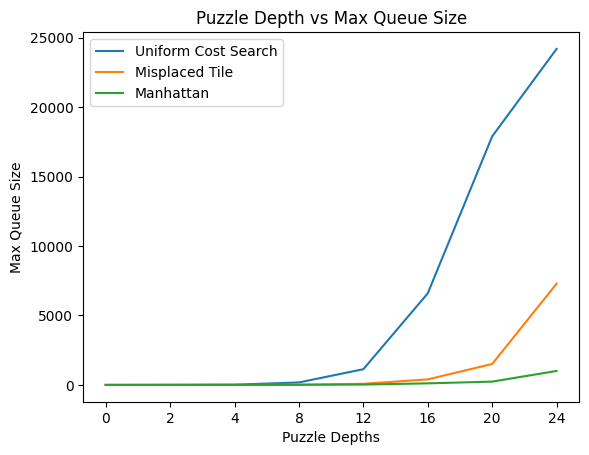

In [356]:
data = DataFrame({'Uniform Cost': uniform[:, 0], 'Misplaced Tile': misplaced[:, 0], 'Manhattan': manhattan[:, 0]})
data.plot(title="Puzzle Depth vs Max Queue Size")
plt.xlabel("Puzzle Depths")
plt.ylabel("Max Queue Size")
plt.xticks(range(8), [0, 2, 4, 8, 12, 16, 20, 24])
plt.show()

### Puzzle Depth vs Nodes Expanded

`Uniform Cost > Misplaced Tile > Manhattan`

The same pattern occurs here as well and this is related to the max queue size. Since a larger queue size also implies that more nodes will be expanded we can confirm that finding with the below graph. Once again the uniform cost and misplaced tile see drastic increases in the same relative spots as they did in regards to queue size.

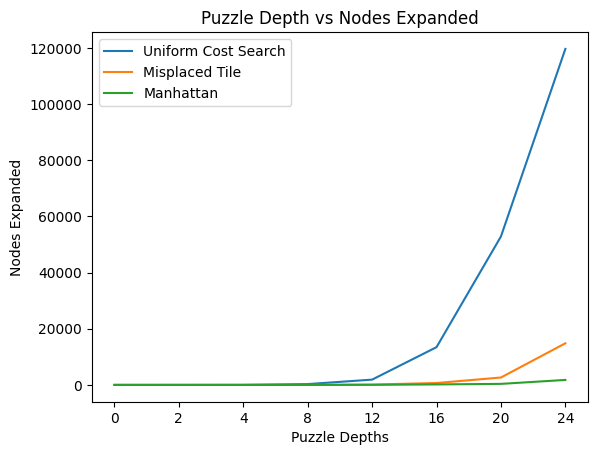

In [357]:
data = DataFrame({'Uniform Cost': uniform[:, 1], 'Misplaced Tile': misplaced[:, 1], 'Manhattan': manhattan[:, 1]})
data.plot(title="Puzzle Depth vs Nodes Expanded")
plt.xlabel("Puzzle Depths")
plt.ylabel("Nodes Expanded")
plt.xticks(range(8), [0, 2, 4, 8, 12, 16, 20, 24])
plt.show()

### Puzzle Depth vs Execution Time

`Uniform Cost > Misplaced Tile > Manhattan`

Although all these times were sub-two seconds it is important to realize that uniform cost search requires significantly more time than both misplaced tile and manhattan combined due to the constant heuristic. Once a slightly helpful heuristic is included the runtime drastically decreases.

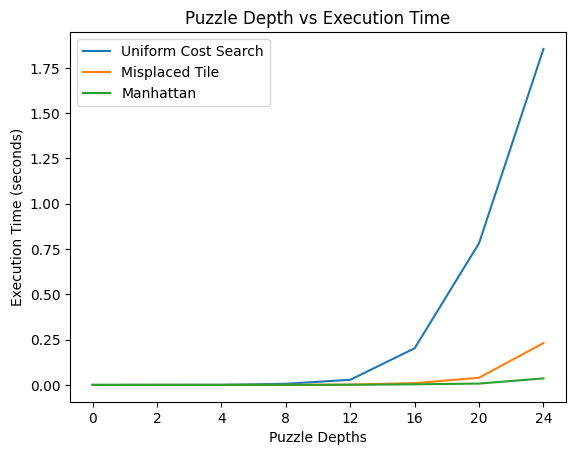

In [358]:
data = DataFrame({'Uniform Cost': uniform[:, 2], 'Misplaced Tile': misplaced[:, 2], 'Manhattan': manhattan[:, 2]})
data.plot(title="Puzzle Depth vs Execution Time")
plt.xlabel("Puzzle Depths")
plt.ylabel("Execution Time (seconds)")
plt.xticks(range(8), [0, 2, 4, 8, 12, 16, 20, 24])
plt.show()

### Tracebacks

All tracebacks for varying solution depths of 0, 2, 4, 8, 12, 16, 20, and 24 can be found in `/outputs/*`. The below code is responsible for running the search algorithms and outputing their results to their appropriate output files.

In [359]:
%%capture cap --no-stderr

names = ["Uniform_Search", "Misplaced_Tile", "Manhattan"]
puzzles = [0, 2, 4, 8, 12, 16, 20, 24]

# iterate through puzzles and algorithms to produce 
for puzzle in range(len(TEST_INITIAL_STATES)):
    for algo in range(len(algorithms)): 
        _, _, output = search(np.array(TEST_INITIAL_STATES[puzzle]), algorithms[algo], silent=False)

        with open(f'./outputs/{names[algo]}_{puzzles[puzzle]}.txt', 'w') as f:
            f.write(output)

## Conclusion

The current project implements just the 8 puzzle, in order to implement larger or smaller puzzles of the same nature, minor changes are required. The only change that would be required would be to insert/remove additional coordinates for the desired puzzle. In addition, the goal state would need to be updated properly to reflect the increase or decrease in tiles. Functions such as the search, heuristics, expansions can remain the same as they are made to adapt to various conditions/sizes for the sliding puzzles. 